In [29]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from snowflake.snowpark import Session
from snowflake.snowpark.functions import col
from snowflake.snowpark.functions import mean, sum
from snowflake.ml.modeling.metrics import correlation

In [58]:
# Create session connection
session = Session.builder.configs(json.load(open("connection.json"))).create()

In [59]:
# Lazy load raw dataframes
raw_data_a = session.table('raw_data_a')
raw_data_b = session.table('raw_data_b')

# Basic EDA

In [60]:
# Select and filter
filtered_data = (
    raw_data_a
    .select("id", "lot", "site")
    .filter(col("lot")
    .is_not_null())
    .distinct()
)

In [61]:
# Aggregate
aggregate_data = (
    raw_data_b
    .filter(col("site").is_not_null())
    .filter(col("weight").is_not_null())
    .group_by("site")
    .agg([
        mean("weight").alias("avg_weight"), 
        sum("count").alias("total_count")
    ])
)

In [62]:
# Join
joined_data = filtered_data.join(
    aggregate_data, filtered_data.site == aggregate_data.site, lsuffix="_l"
).drop("site_l")

In [63]:
# Get summary statistics
joined_data.describe().show()

--------------------------------------------------------------------------------------------------------------------------
|"SUMMARY"  |"ID"                                  |"LOT"   |"SITE"             |"AVG_WEIGHT"        |"TOTAL_COUNT"      |
--------------------------------------------------------------------------------------------------------------------------
|count      |7621                                  |7621    |7621.0             |7621.0              |7621.0             |
|stddev     |NULL                                  |NULL    |574.5908450201761  |11711.978793924818  |6607674.476405063  |
|mean       |NULL                                  |NULL    |2819.388532        |33063.1033801827    |4959110.616848183  |
|max        |FFF096F2-AC77-4D5B-B3AB-EB4FBCB4503B  |400008  |3810.0             |62829.6132950723    |35379885.0         |
|min        |0003AFB1-A656-487F-B917-CC4A908A7C1E  |18153   |2010.0             |10236.626932515337  |7617.000000000002  |
----------------

In [64]:
# View data
joined_data.show()

---------------------------------------------------------------------------------------------------
|"ID"                                  |"LOT"  |"SITE"  |"AVG_WEIGHT"        |"TOTAL_COUNT"       |
---------------------------------------------------------------------------------------------------
|270A248A-00B0-468A-8ACF-0AB389845D11  |22835  |2205    |45129.133115202916  |279460.0000000001   |
|B666F575-E501-4A66-A099-9635AFDEF405  |19189  |2205    |45129.133115202916  |279460.0000000001   |
|04641B78-1AF8-479A-84D5-AF74ED67CA9E  |22822  |2205    |45129.133115202916  |279460.0000000001   |
|611EEF8C-2EAE-4B24-8181-001E7552D79B  |22786  |2205    |45129.133115202916  |279460.0000000001   |
|3F904EE7-31A8-4AB6-B002-06B2DEF6CD39  |22908  |2205    |45129.133115202916  |279460.0000000001   |
|C805FA1D-3FE6-4C30-BA9F-FEA45310C98C  |19176  |2540    |23246.542556083677  |177107.00000000003  |
|799994FB-9707-4026-B2D5-78D9C27ACE77  |19731  |2540    |23246.542556083677  |177107.00000000003  |


# Correlation

In [65]:
# Compute correlations on the dataframe
correlations = correlation(df=joined_data)

Got error object of type 'NoneType' has no len() when trying to read default values from function: <class 'snowflake.ml.modeling.metrics.metrics_utils.register_sharded_dot_sum_computer.<locals>.ShardedDotAndSumComputer'>. Proceeding without creating optional arguments
Got error object of type 'NoneType' has no len() when trying to read default values from function: <class 'snowflake.ml.modeling.metrics.metrics_utils.register_accumulator_udtf.<locals>.Accumulator'>. Proceeding without creating optional arguments


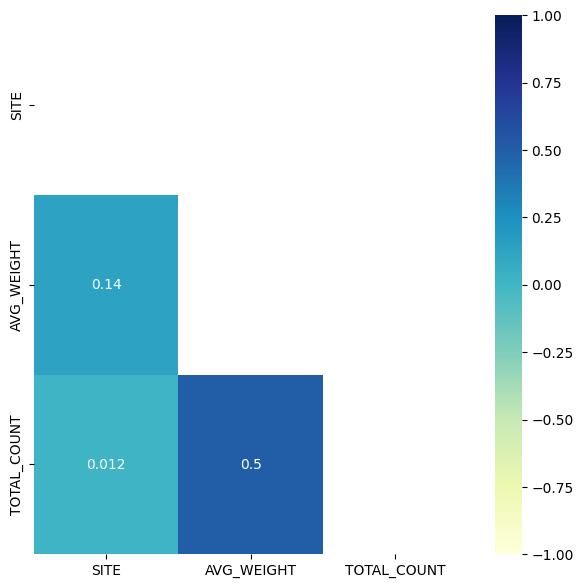

In [66]:
# Visualize correlation data
mask = np.triu(np.ones_like(correlations, dtype=bool))
plt.figure(figsize=(7, 7))
heatmap = sns.heatmap(
    correlations, 
    mask=mask, 
    cmap="YlGnBu", 
    annot=True, 
    vmin=-1, 
    vmax=1
)